In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as stats

import src.wrangle as wr

In [64]:
from importlib import reload

In [65]:
df = wr.get_shelter_data()

In [66]:
train, _, _ = wr.split_data(df)

<Figure size 1440x432 with 0 Axes>

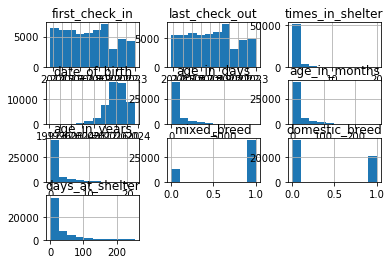

In [7]:
plt.figure(figsize=(20, 6))
train.hist()
plt.show()

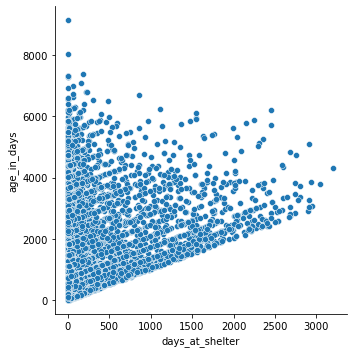

In [53]:
sns.relplot(data=train, x='days_at_shelter', y='age_in_days')

In [68]:
cat_vars = ['animal_type', 'sex', 'breed', 'color', 'intake_type', 'intake_condition', \
               'sterilized', 'sex_of_animal', 'unknown_breed', 'mixed_breed', 'domestic_breed',
       'pitbull', 'boxer']
alpha = 0.05

In [70]:
def get_p_values(df, cat_vars, target):
    '''
    accepts a data frame and the list of categorical column names
    returns a data frame with p_values of all categorical variables
    '''

    #dictionary to hold names of the column and a p_value assotiated with it
    p_v = {}
    #for every column in category variables run a chi2 test
    for col in cat_vars:
        #create a crosstable
        observed = pd.crosstab(df[col], df[target])
        #run a chi squared test fot categorical data
        test = stats.chi2_contingency(observed)
        p_value = test[1]
        #add the result to the dictionary
        p_v[col] = p_value
        
        #transform a dictionary to Series and then to Data Frame
        p_values = pd.Series(p_v).reset_index()
        p_values.rename(columns = {'index':'Feature', 0:'P_value'}, inplace = True)
        p_values = p_values.sort_values(by='P_value')

        #add the column that shows if the result is significant
        p_values['is_significant'] = p_values['P_value'] < alpha
    
    return p_values

In [117]:
get_p_values(df, cat_vars, 'outcome_type').sort_values(by='P_value')

,Feature,P_value,is_significant
0,animal_type,0.000000e+00,True
1,sex,0.000000e+00,True
4,intake_type,0.000000e+00,True
5,intake_condition,0.000000e+00,True
6,sterilized,0.000000e+00,True
7,sex_of_animal,0.000000e+00,True
3,color,3.422400e-277,True
2,breed,1.352134e-273,True
10,domestic_breed,3.780397e-118,True
9,mixed_breed,6.764281e-96,True


In [127]:
def chi2_categorical_test(df, target_var, test_var_list):
    '''
    The chi2 test is used to determine if a statistically significant relationship
    exists between two categorical variables
    This function takes in a list of variables to test against a singular target variable
    returning a dataframe which should help to determine if the list of variables should
    be accepted or rejected for use in a model to explain the target variable
    '''
    chi2_df = pd.DataFrame(columns=['Potential_Feature', 'Chi2_stat', 'P-Value', 'Significance', 'Keep'])

    for item in test_var_list:
        ctab = pd.crosstab(df[item],df[target_var])
        chi, p_value, _, _ = stats.chi2_contingency(ctab)
        if 1 - p_value >= 0.95:
            keeper = 'Yes'
        else:
            keeper = 'No'
        chi2_df.loc[len(chi2_df)] = [item, chi, p_value, 1-p_value, keeper]
    return chi2_df

In [111]:
df = wr.get_shelter_data()

In [112]:
train, _, _ = wr.split_data(df)

In [74]:
adopted = train[train.outcome_type == 'Adoption']
transfered = train[train.outcome_type == 'Transfer']
euthanized = train[train.outcome_type == 'Euthanasia']
died = train[train.outcome_type == 'Died']
list_of_outcomes = [adopted, transfered, euthanized, died]
dict_of_outcomes = {
    'adopted':adopted,
    'transfered':transfered,
    'euthanized':euthanized,
    'died':died   
}

In [75]:
num_cols = ['times_in_shelter', 'age_in_days', 'age_in_months', 'age_in_years', 
            'days_at_shelter', 'age_on_check_in']

In [98]:
num_p_values = pd.DataFrame(columns=['variable', 'outcome', 'p_value', 'significance'])

In [99]:
num_p_values.drop(num_p_values.index, axis=0, inplace=True)

In [100]:
num_p_values

,variable,outcome,p_value,significance


In [76]:
def test_num_values():
    '''
    runs a 1 sample t-test for numerical variables of each outcome
    '''
    num_p_values = pd.DataFrame(columns=['variable', 'outcome', 'p_value', 'significance'])
    for col in num_cols:
        for key in dict_of_outcomes:
            t, p = stats.ttest_1samp(dict_of_outcomes[key][col], train[col].mean())
            num_p_values.loc[len(num_p_values)] = [col, key, p, p<alpha]
    return num_p_values

In [77]:
test_num_values()

,variable,outcome,p_value,significance
0,times_in_shelter,adopted,8.513371e-19,True
1,times_in_shelter,transfered,5.089450e-89,True
2,times_in_shelter,euthanized,2.496608e-04,True
3,times_in_shelter,died,1.027065e-27,True
4,age_in_days,adopted,2.630215e-06,True
5,age_in_days,transfered,5.520202e-03,True
6,age_in_days,euthanized,2.136645e-34,True
7,age_in_days,died,1.975657e-02,True
8,age_in_months,adopted,2.467185e-06,True
9,age_in_months,transfered,5.345110e-03,True


In [106]:
stats.ttest_1samp(adopted.times_in_shelter, train.times_in_shelter.mean())

Ttest_1sampResult(statistic=8.85768242417611, pvalue=8.513370931933245e-19)

### 1. What percentage of animals is adopted, transfered, euthanized or died of natural conditions?

In [ ]:
# Hello Ryan!
piechart_labels = ['Adopted', 'Transfered', 'Euthanized', 'Died']

In [163]:
values.tolist()

[0.7, 0.27, 0.03, 0.01]

In [81]:
values = train.outcome_type.value_counts().tolist()
piechart_labels = ['Adopted', 'Transfered', 'Euthanized', 'Died']
flare = sns.color_palette('flare')
flare = sns.color_palette('Accent')
set2 = sns.color_palette('Set2')

In [82]:
sns.color_palette('Set2')

[(0.4, 0.7607843137254902, 0.6470588235294118),
 (0.9882352941176471, 0.5529411764705883, 0.3843137254901961),
 (0.5529411764705883, 0.6274509803921569, 0.796078431372549),
 (0.9058823529411765, 0.5411764705882353, 0.7647058823529411),
 (0.6509803921568628, 0.8470588235294118, 0.32941176470588235),
 (1.0, 0.8509803921568627, 0.1843137254901961),
 (0.8980392156862745, 0.7686274509803922, 0.5803921568627451),
 (0.7019607843137254, 0.7019607843137254, 0.7019607843137254)]

In [83]:
def autopct_format(values):
        def my_format(pct):
            total = sum(values)
            val = int(round(pct*total/100.0))
            return '{:.1f}%)'.format(pct, v=val)
        return my_format

In [97]:
# define the default font sizes
plt.rc('font', size=16)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

In [84]:
def viz_animals_outcome():
    plt.figure(figsize=(8, 8))
    plt.pie(values, labels=piechart_labels, explode=[0.01, 0.02, 0.03, 0.04], 
            colors=set2, autopct=autopct_format(values),
            shadow=True)
    plt.title('Animal\'s outcome')
    plt.show()

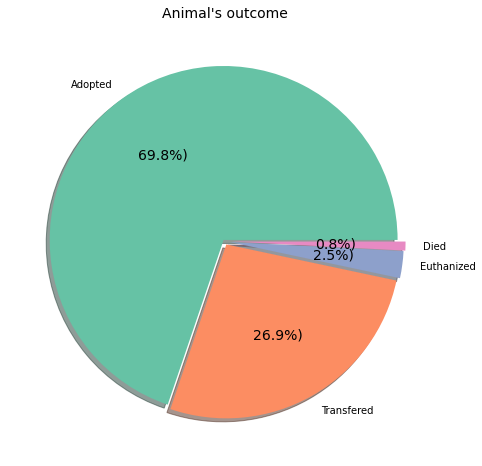

In [87]:
viz_animals_outcome()

In [88]:
cats = train[train.animal_type == 'Cat']
dogs = train[train.animal_type == 'Dog']
rabbits = train[train.animal_type == 'Rabbit']
others = train[(train.animal_type == 'Wild') | (train.animal_type == 'Bird') \
                                            | (train.animal_type == 'Guinea Pig') \
                                            | (train.animal_type == 'Livestock')]
animal_type_dict = {
    'Cats':cats,
    'Dogs':dogs,
    'Rabbits':rabbits,
    'Others':others
}

In [93]:
# plotting defaults
#plt.rc('figure', figsize=(13, 7))
plt.style.use('seaborn-whitegrid')
plt.rc('font', size=16)

### 2. Is animal type connected to the outcome?

In [101]:
def viz_animal_type_vs_outcome():
    '''
    the functions shows pie charts for cats/ dogs/ rabbits and other animals
    showing their outcome types
    '''
    plt.figure(figsize=(16, 8))
    for i, key in enumerate(animal_type_dict):
        plt.subplot(2, 2, i+1)
        plt.title('\n' + key + '\n')
        v = animal_type_dict[key].outcome_type.value_counts().tolist()
        labels = animal_type_dict[key].outcome_type.value_counts().index.tolist()
        labels[3] = ''
        patches, text = plt.pie(v, labels=labels, explode=[0.01, 0.02, 0.03, 0.07], 
            colors=set2, shadow=True)

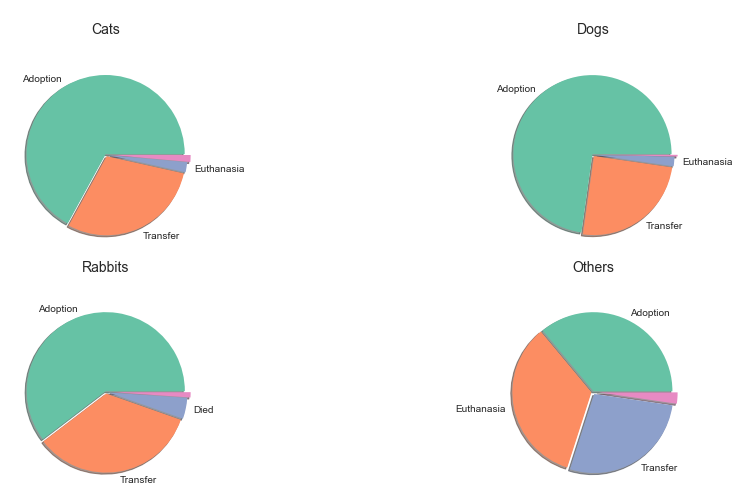

In [102]:
viz_animal_type_vs_outcome()

In [215]:
text

[Text(0.4707239393852963, 1.0052457276156852, 'Adoption'),
 Text(-1.0994568184644697, -0.2135291650617925, 'Euthanasia'),
 Text(0.5977292708473253, -0.9589680488797973, 'Transfer'),
 Text(1.1370145735711885, -0.08244913272271964, 'Died')]

In [178]:
train.animal_type.value_counts()

Dog           31448
Cat           22080
Wild            426
Rabbit          371
Bird            247
Guinea Pig      183
Livestock        12
Name: animal_type, dtype: int64

In [203]:
plt.pie?

### 3. Does the sex of the animal have a relationship to the outcome?

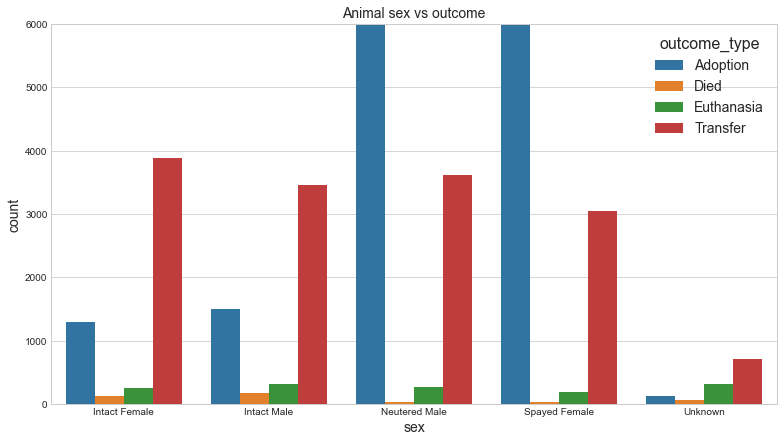

In [114]:
sns.countplot(data=train, x='sex', hue='outcome_type')
plt.title('Animal sex vs outcome')
plt.ylim(0, 6000)
plt.show()

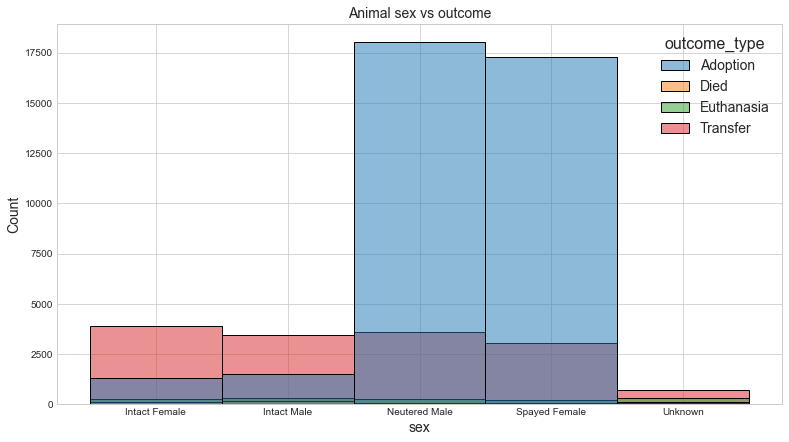

In [103]:
def viz_sex():
    '''
    the function shows the 
    '''
    sns.histplot(data=train, x='sex', hue='outcome_type')
    plt.title('Animal sex vs outcome')
    plt.show()

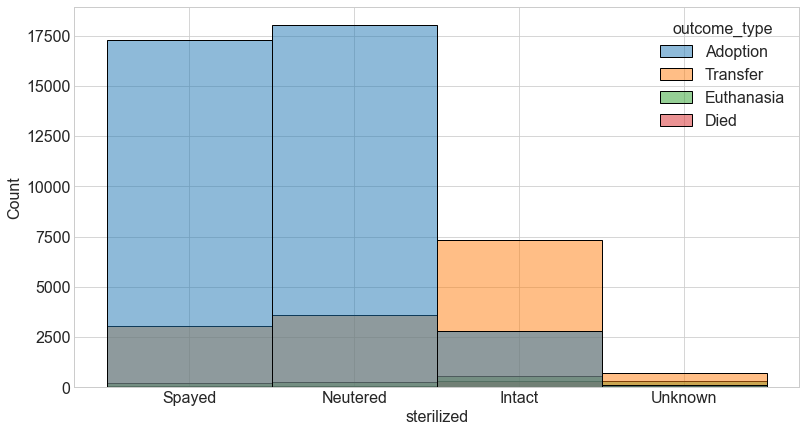

In [118]:
def sex_vs_outcome():
    '''
    returns 2 subplots that show outcomes for males/females and intact or sterilized animals
    '''
    plt.figure(figsize=(20, 6))
    plt.subplot(121)
    sns.histplot(data=train, x='sterilized', hue='outcome_type')
    plt.title('Neutered/Spayed vs Intact')
    plt.ylim(0, 20_000)
    plt.subplot(122)
    sns.histplot(data=train, x='sex_of_animal', hue='outcome_type')
    plt.title('Male vs Female')
    plt.ylim(0, 20_000)
    plt.show()

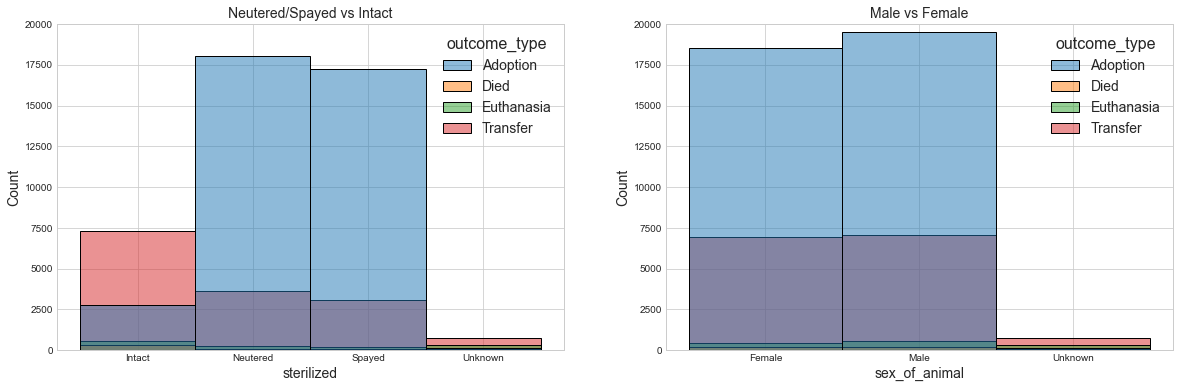

In [119]:
sex_vs_outcome()

### 4. Is the age of the animal connected to the outcome type?

In [126]:
def age_vs_outcome():
    '''
    the function visualize the mean age of animal in month and outcomes
    '''
    graph = sns.barplot(y='age_in_months',  x='outcome_type', estimator=np.median, data=train,\
                        order = ['Adoption', 'Transfer', 'Euthanasia', 'Died'], palette='Accent')
    graph.axhline(train.age_in_months.median(), color = (0.4, 0.4, 0.4), label = 'median age')
    graph.axhline(train.age_in_months.mean(), color = 'red', label = 'mean age')
    plt.title('Age of the animal in months vs Outcome type\n')
    plt.text(-0.4, 20.1, 'max age = ' + str(train.age_in_years.max()) + 'years')
    plt.legend()
    plt.show()

In [124]:
sns.barplot?

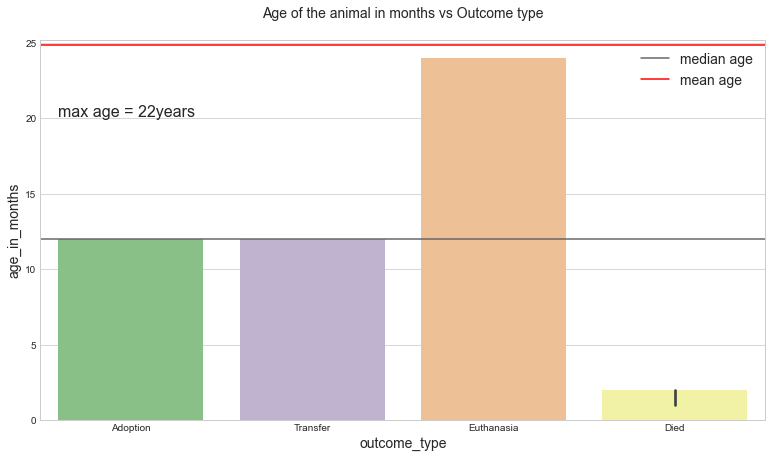

In [127]:
age_vs_outcome()

### 5. How differ the average age of the animal from its type? And how does it affect the outcome type?

In [128]:
def viz_age_type_outcome():
    '''
    the function shows the median age of each animal and highlights the outcome type for each animal type group
    '''
    sns.barplot(x='animal_type', y='age_in_months', hue='outcome_type', data=train, palette=set2)
    plt.title('Animal\'s age, type and the outcome in shelter \n')
    plt.show()

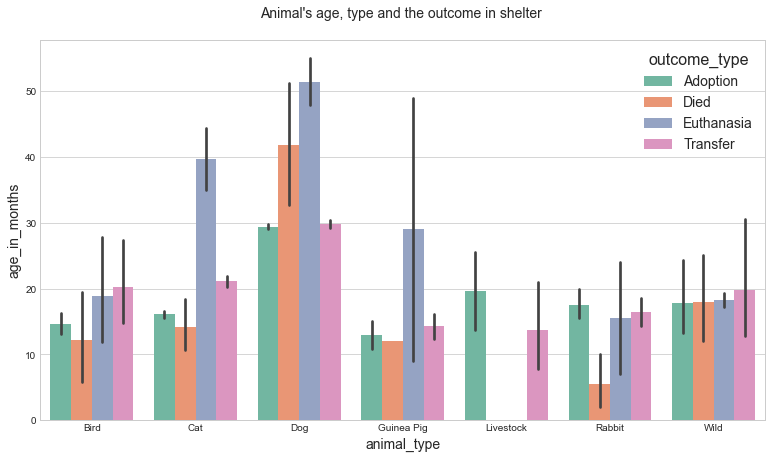

In [129]:
viz_age_type_outcome()

Old guinea pigs and old cats have must higher chances to be euthanized 

(array([    0.,  5000., 10000., 15000., 20000., 25000., 30000.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

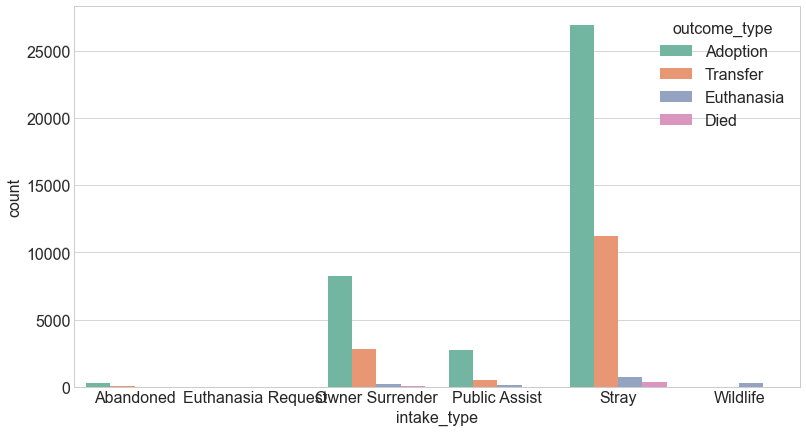

In [303]:
sns.countplot(x='intake_type', hue='outcome_type', data=train, palette=set2)
plt.yticks(rotation = 0.45)

<AxesSubplot:xlabel='domestic_breed', ylabel='count'>

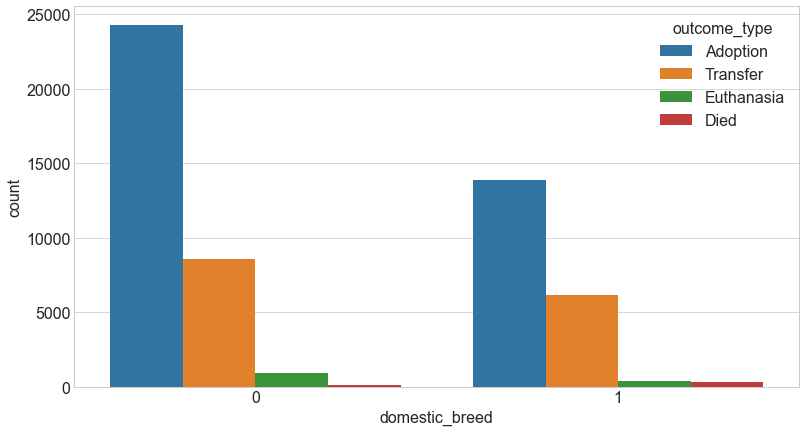

In [308]:
sns.countplot(data=train, x='domestic_breed', hue='outcome_type')

<AxesSubplot:xlabel='mixed_breed', ylabel='count'>

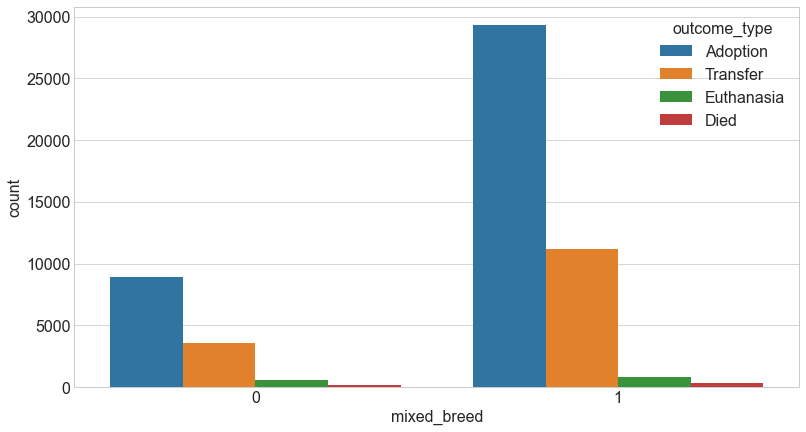

In [309]:
sns.countplot(data=train, x='mixed_breed', hue='outcome_type')

## Requirements:
- 3+ stat tests
- exploration summarized (takeaways)
- 6+ visualizations 
- 4+ questions

In [273]:
plt.text?

## Top 10 breeds

In [68]:
top10_breeds = pd.DataFrame()
top10_breeds['overall'] = train.breed.value_counts().head(10).index
top10_breeds['adopted'] = adopted.breed.value_counts().head(10).index
top10_breeds['transfered'] = transfered.breed.value_counts().head(10).index
top10_breeds['euthanized'] = euthanized.breed.value_counts().head(10).index
top10_breeds['died'] = died.breed.value_counts().head(10).index

In [69]:
top10_breeds

,overall,adopted,transfered,euthanized,died
0,Domestic,Domestic,Domestic,Domestic,Domestic
1,Pit Bull,Pit Bull,Pit Bull,Unknown,Unknown
2,Labrador Retriever,Labrador Retriever,Chihuahua Shorthair,Pit Bull,Chihuahua Shorthair
3,Chihuahua Shorthair,Chihuahua Shorthair,Labrador Retriever,Labrador Retriever,Labrador Retriever
4,German Shepherd,German Shepherd,Unknown,Chihuahua Shorthair,Pit Bull
5,Unknown,Australian Cattle Dog,German Shepherd,German Shepherd,Australian Cattle Dog
6,Australian Cattle Dog,Unknown,Australian Cattle Dog,Australian Cattle Dog,German Shepherd
7,Siamese,Siamese,Siamese,Siamese,Siamese
8,Dachshund,Siberian Husky,Dachshund,Boxer,Anatol Shepherd
9,Siberian Husky,Dachshund,Great Pyrenees,Siberian Husky,Great Pyrenees


In [44]:
df.breed = np.where(df.breed.str.contains(' Mix'), df.breed.str.strip(' Mix'), df.breed)
df.breed = np.where(df.breed.str.contains('Domestic'), 'Domestic', df.breed)
df.breed = np.where(df.breed.str.contains('Boxer'), 'Boxer', df.breed)
df.breed = np.where(df.breed.str.contains('Pit Bull'), 'Pit Bull', df.breed)

In [46]:
df.breed = np.where(df.breed.str.contains('Domestic'), 'Domestic', df.breed)

In [51]:
df.breed = np.where(df.breed.str.contains('Pit Bull'), 'Pit Bull', df.breed)

In [ ]:
df.breed = np.where(df.breed.str.contains('Pit Bull'), 'Pit Bull', df.breed)

In [ ]:
# wrangle df
'''
str.contains('Domestic') --> 'Domestic'
strip ' Mix'
then re-run all code
'''

In [107]:
top10_colors = pd.DataFrame()
top10_colors['overall'] = train[train.animal_type=='Cat'].color.value_counts().head(10).index
top10_colors['adopted'] = adopted[adopted.animal_type == 'Cat'].color.value_counts().head(10).index
top10_colors['transfered'] = transfered[transfered.animal_type == 'Cat'].color.value_counts().head(10).index
top10_colors['euthanized'] = euthanized[euthanized.animal_type == 'Cat'].color.value_counts().head(10).index
top10_colors['died'] = died[died.animal_type == 'Cat'].color.value_counts().head(10).index

In [108]:
top10_colors

,overall,adopted,transfered,euthanized,died
0,Brown Tabby,Brown Tabby,Brown Tabby,Brown Tabby,Brown Tabby
1,Black,Black,Black,Black,Black
2,Black/White,Black/White,Black/White,Black/White,Black/White
3,Brown Tabby/White,Brown Tabby/White,Brown Tabby/White,Brown Tabby/White,Brown Tabby/White
4,Orange Tabby,Orange Tabby,Orange Tabby,Orange Tabby,Tortie
5,Tortie,Tortie,Tortie,Calico,Orange Tabby
6,Calico,Calico,Calico,Blue Tabby,Orange Tabby/White
7,Blue Tabby,Blue Tabby,Blue,Orange Tabby/White,Calico
8,Orange Tabby/White,Orange Tabby/White,Blue Tabby,Tortie,Blue Tabby
9,Blue,Blue,Orange Tabby/White,Blue,White/Black


In [ ]:
# even color shows significance, it's hard to find what color is really  important

In [105]:
# general
top10_colors

,overall,adopted,transfered,euthanized,died
0,Black/White,Black/White,Black/White,Brown,Black
1,Black,Black,Black,Black/White,Brown Tabby
2,Brown Tabby,Brown Tabby,Brown Tabby,Black,Black/White
3,White,Brown/White,White,Brown Tabby,Brown Tabby/White
4,Brown/White,White,Brown Tabby/White,White,White/Black
5,Brown Tabby/White,Tan/White,Orange Tabby,Blue/White,Tortie
6,Tan/White,Brown Tabby/White,Brown/White,Brown/White,Orange Tabby/White
7,Orange Tabby,White/Black,White/Black,Brown/Black,Orange Tabby
8,White/Black,Orange Tabby,Tan,Brown Tabby/White,White
9,Brown,Blue/White,Tan/White,White/Brown,Brown


In [70]:
adopted.animal_type.value_counts()

Dog           22884
Cat           14800
Rabbit          224
Bird            134
Guinea Pig       88
Wild             83
Livestock         8
Name: animal_type, dtype: int64

In [71]:
transfered.animal_type.value_counts()

Dog           7843
Cat           6510
Rabbit         127
Guinea Pig      92
Bird            88
Wild            56
Livestock        4
Name: animal_type, dtype: int64

In [72]:
euthanized.animal_type.value_counts()

Dog           614
Cat           458
Wild          276
Bird           17
Rabbit          4
Guinea Pig      2
Livestock       0
Name: animal_type, dtype: int64

In [73]:
died.animal_type.value_counts()

Cat           312
Dog           107
Rabbit         16
Wild           11
Bird            8
Guinea Pig      1
Livestock       0
Name: animal_type, dtype: int64

In [ ]:
transfered['age_on_check_in'] = 

In [86]:
(euthanized.last_check_out - euthanized.first_check_in).mean()

Timedelta('53 days 07:59:43.194748359')

In [76]:
transfered.age_in_days

62123     155
33134      58
126948    125
174900    609
105966    649
         ... 
148736    370
156879    368
60620     378
66706     788
157713    374
Name: age_in_days, Length: 14720, dtype: int64